<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/deep/intro_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image recognition using CNNs

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.4.1'

In [4]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-6acfbb78-cd9c-7879-e3c2-b269d971277c)


In [6]:
!nvidia-smi

Fri May 14 17:36:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# if we do not want GPU
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [9]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [10]:
# https://github.com/keisen/tf-keras-vis
# https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb
!pip install -q tf-keras-vis

In [11]:
from lrcurve import KerasLearningCurve

# Our example: Recognizing Speed Limit Signs

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/img/speed-limit-signs.png?raw=1'>

## Getting the data

In [18]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/speed-limit-signs.zip
!unzip -qo speed-limit-signs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1795k  100 1795k    0     0  6775k      0 --:--:-- --:--:-- --:--:-- 6775k


In [19]:
# !ls -lR speed-limit-signs
!ls -lh speed-limit-signs

total 28K
drwxr-xr-x 2 root root 4.0K May 14 17:36 0
drwxr-xr-x 2 root root 4.0K May 14 17:36 1
drwxr-xr-x 2 root root 4.0K May 14 17:36 2
drwxr-xr-x 2 root root 4.0K May 14 17:36 3
drwxr-xr-x 2 root root 4.0K May 14 17:36 4
drwxr-xr-x 2 root root 4.0K May 14 17:36 5
-rw-r--r-- 1 root root  407 Aug 28  2019 README.md


In [20]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

## Loading and pre-processing

In [21]:
import os
from skimage import data, io, filters

ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
type = ".ppm"

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d))]
# Loop through the label directories and collect the data in
# two lists, labels and images.
labels = []
images = []
for d in directories:
    label_dir = os.path.join(data_dir, d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for f in file_names:
        images.append(io.imread(f))
        labels.append(int(d))

images, labels = np.array(images), np.array(labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [22]:
images.shape

(379,)

In [23]:
labels.shape

(379,)

In [24]:
unique_values, counts = np.unique(labels, return_counts=True)
classes = len(unique_values)
unique_values, counts, classes

(array([0, 1, 2, 3, 4, 5]), array([79, 81, 68, 53, 41, 57]), 6)

In [25]:
label_names = ['30', '50', '70', '80', '100', '120']

### First image for each Label

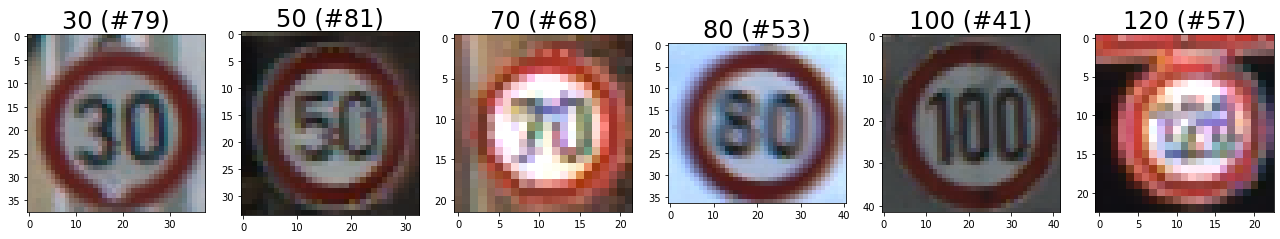

In [26]:
plt.figure(figsize=(30, 15))

i = 1
for label in unique_values:
    # Pick the first image for each label.
    image = images[np.where(labels == label)[0][0]]
    plt.subplot(1, 8, i)
    plt.title("{0} (#{1})".format(label_names[label], counts[label]))
    i += 1
    plt.imshow(image)

### Ooops, different resolutions (as you can see from the axes)

We need to have all of them with the same resolution

In [27]:
import skimage.transform

images_32 = np.array([skimage.transform.resize(image, (32, 32)) for image in images])

In [28]:
# 379 samples, 32x32 resoltion, 3 color channels
images_32.shape

(379, 32, 32, 3)

# How to tackle this using neural networks?

In [29]:
# turns whatever labels we have into a range of numbers
# not needed here as our signs actually are numbers already, but needed for the general case

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(unique_values)
int_labels = le.transform(labels)
# int_labels

In [30]:
X = images_32
y = int_labels

In [31]:
y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((303, 32, 32, 3), (76, 32, 32, 3), (303,), (76,))

## CNNs

_a strongly simplified VGG architecture can already overfit, so it has enough capacity_

In [33]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

model = tf.keras.Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3))) 
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

In [34]:
# this is no fun on CPU, on a weak i5 this takes up to 10 minutes, on decent gpu just under a minute
%%time

BATCH_SIZE = 50
EPOCHS = 500

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.2,
                    callbacks=[KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 38.9 s, sys: 2 s, total: 40.9 s
Wall time: 40.5 s


## Evaluation

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(model, X, y, file_name=None):
    y_pred = model.predict(X, batch_size=BATCH_SIZE).argmax(axis=1)
    cm = confusion_matrix(y, y_pred)
    figure = plt.figure(figsize=(10, 10))

    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [36]:
def plot_accuracy(history, file_name=None):
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Accuracy', 'Validation Accuracy']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [37]:
def plot_loss(history, file_name=None):
    plt.figure()

    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.yscale('log')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Loss', 'Validation Loss']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [38]:
def plot_gallery(model, X, y, size=15, file_name=None):
    y_pred_raw = model.predict(X, batch_size=BATCH_SIZE)
    certainty = y_pred_raw.max(axis=1)
    y_pred = y_pred_raw.argmax(axis=1)

    figure = plt.figure(figsize=(40, 12))
    # plt.title('Test Samples')
    if size:
        samples = np.random.choice(X.shape[0], size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, X.shape[0])
    for i, index in enumerate(samples):
        ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        # Display each image
        ax.imshow(np.squeeze(X[index]), cmap='gray')
        predict_index = y_pred[index]
        true_index = y[index]
        # Set the title for each image
        ax.set_title("{} ({} / {}) {:.2f}: {}".format(
                                    label_names[predict_index], 
                                    label_names[true_index],
                                    true_index,
                                    certainty[index],
                                    index),
                                      color=("green" if predict_index == true_index else "red"))
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)
    return certainty.max(), certainty.min(), certainty.mean()

In [39]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.02090989612042904, 0.9933993220329285)

In [40]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.27884140610694885, 0.9078947305679321)

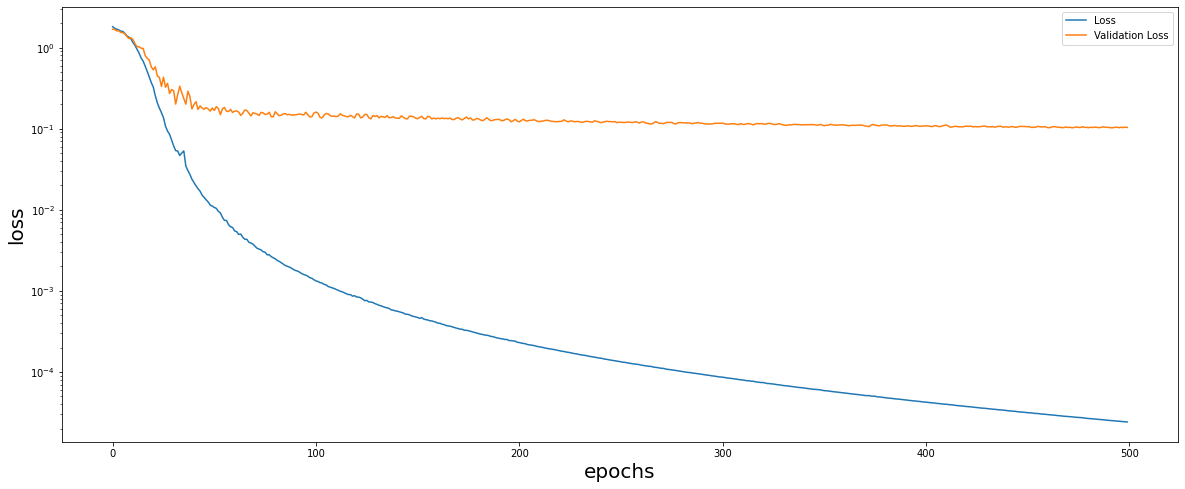

In [41]:
plot_loss(history)

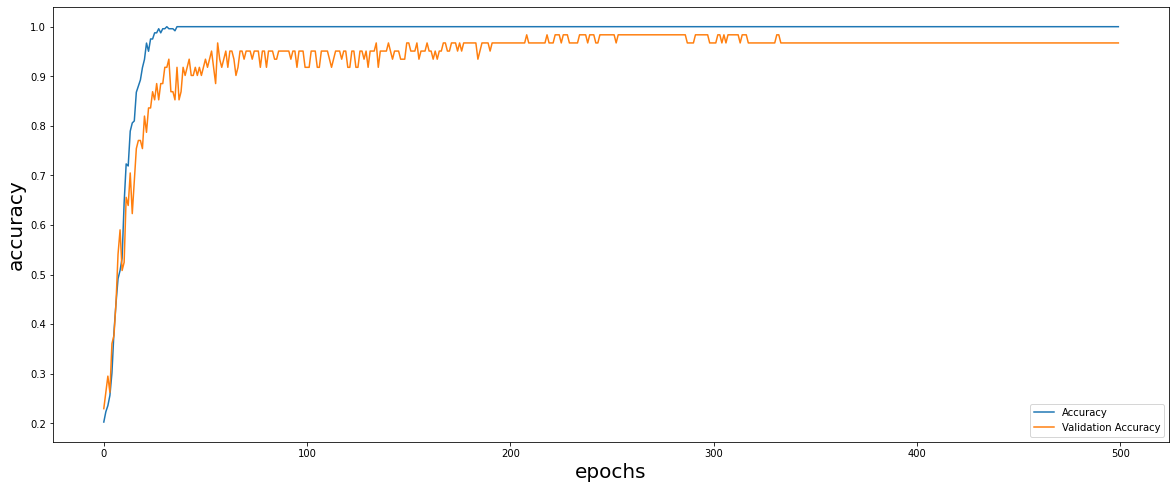

In [42]:
plot_accuracy(history)

In [43]:
y_pred = model.predict(X).argmax(axis=1)
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,

## Confusion Matrix
* row: true
* column: predicted

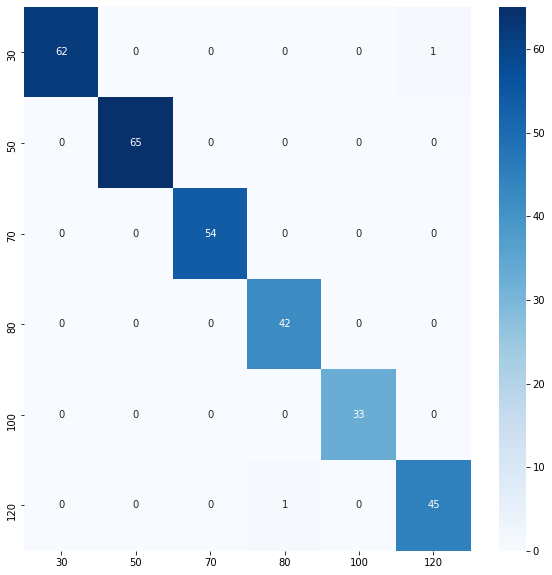

In [44]:
plot_cm(model, X_train, y_train)

(1.0, 0.49530756, 0.9878716)

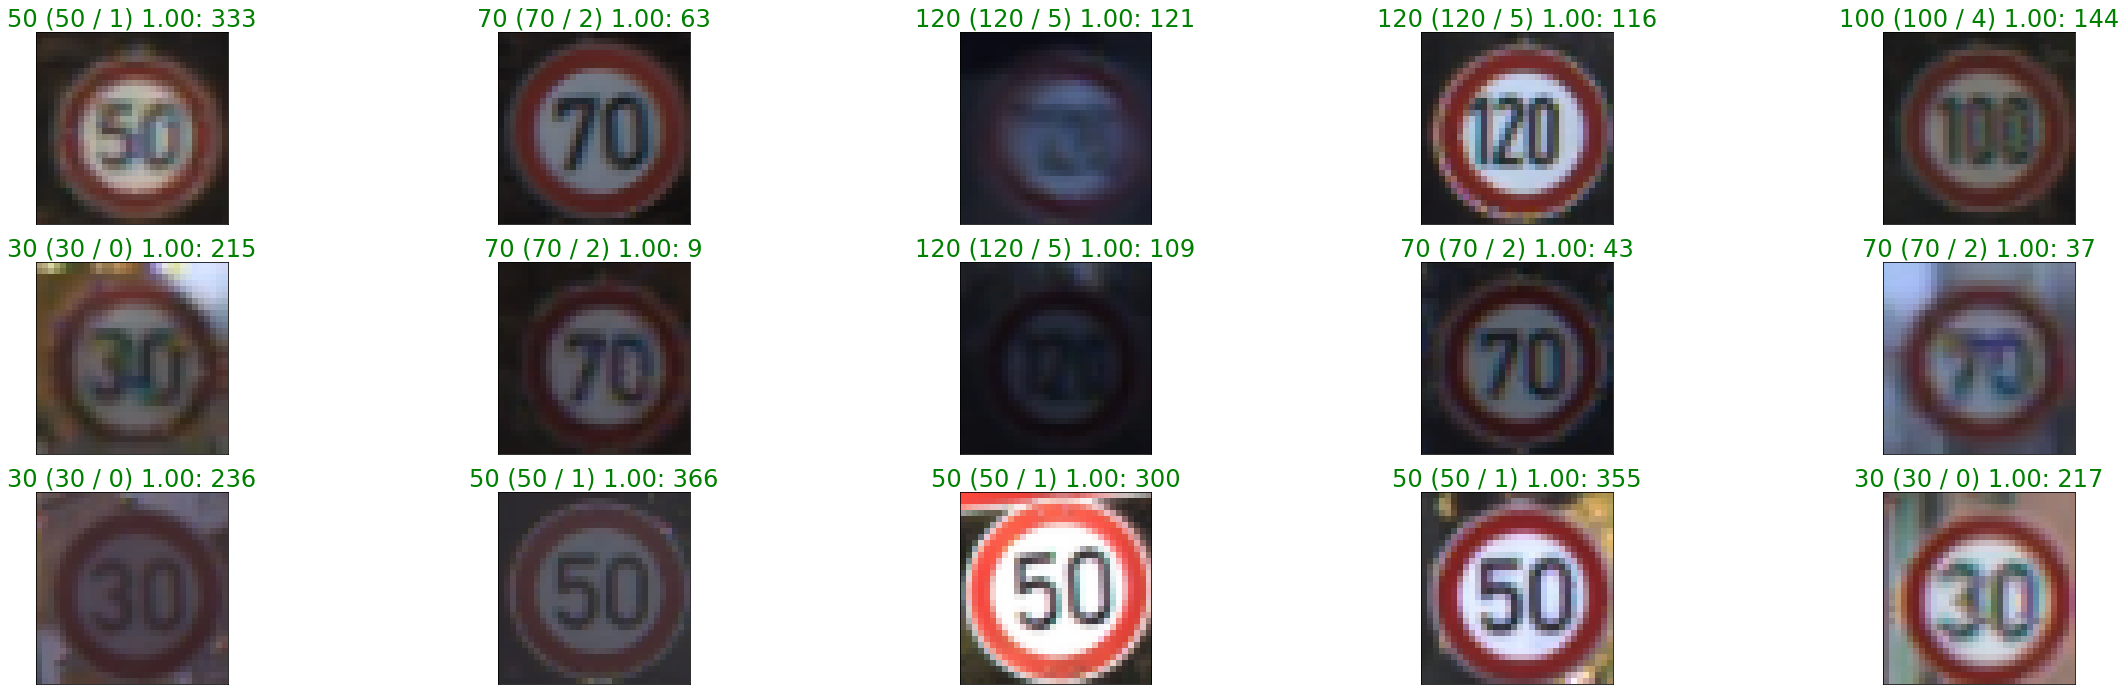

In [45]:
plot_gallery(model, X, y)

In [46]:
model.save('speed-signs-simple.h5')

# Exercise: Prevent Overfitting on our VGG model

_For CNN you use the same means of regularization as for other NNs_

Log each experiment and all the parameters that seem relevant

Things you can try
* add Dropout (already prepared)
  * sort of ensemble learning - only use a certain amount of all neurons for each batch
* add BatchNormalization (already prepared)
  * normalize each batch to make it easier to digest for next layer
* train for more/less epochs
* other/more/less layers
* less/more nodes per layer
* different sequence, less/more filters
* higher batch size
* other optimizer

In [47]:
# * https://mlflow.org/
#   * https://mlflow.org/docs/latest/quickstart.html
#   * https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html
# * https://github.com/mlflow/mlflow
# https://stackoverflow.com/questions/61615818/setting-up-mlflow-on-google-colab
# https://mlflow.org/docs/latest/quickstart.html#using-the-tracking-api

!pip install mlflow --quiet
!pip install pyngrok --quiet

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

     |████████████████████████████████| 14.2MB 14.7MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 1.1MB 31.3MB/s 
     |████████████████████████████████| 153kB 51.0MB/s 
     |████████████████████████████████| 174kB 54.0MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 747kB 14.4MB/s 
MLflow Tracking UI: https://04bcf56c57d8.ngrok.io


In [48]:
X_experiment, X_val, y_experiment, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_experiment.shape, X_val.shape, y_experiment.shape, y_val.shape

((242, 32, 32, 3), (61, 32, 32, 3), (242,), (61,))

Model: "Custom_VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0

CPU times: user 39.6 s, sys: 1.61 s, total: 41.2 s
Wall time: 41.9 s


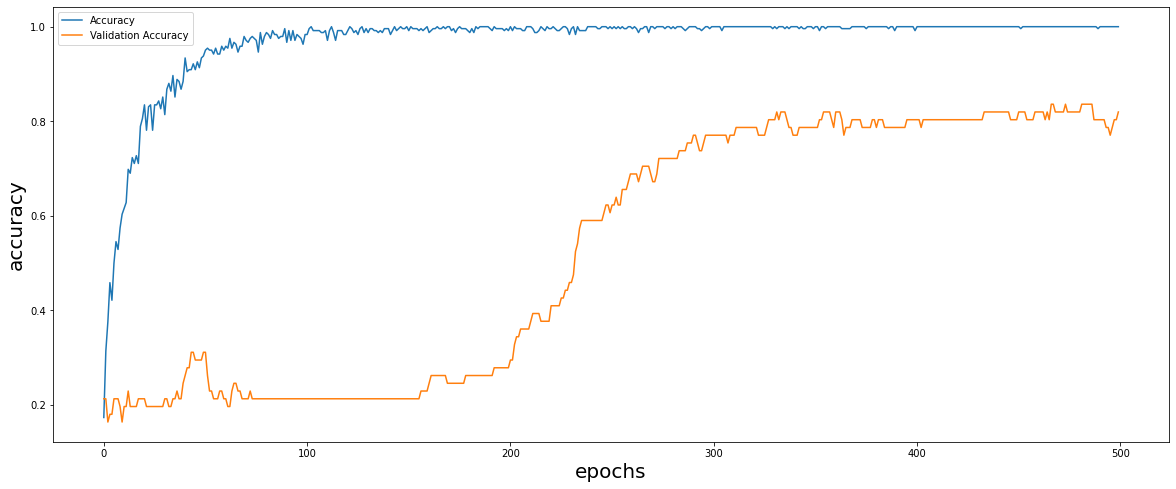

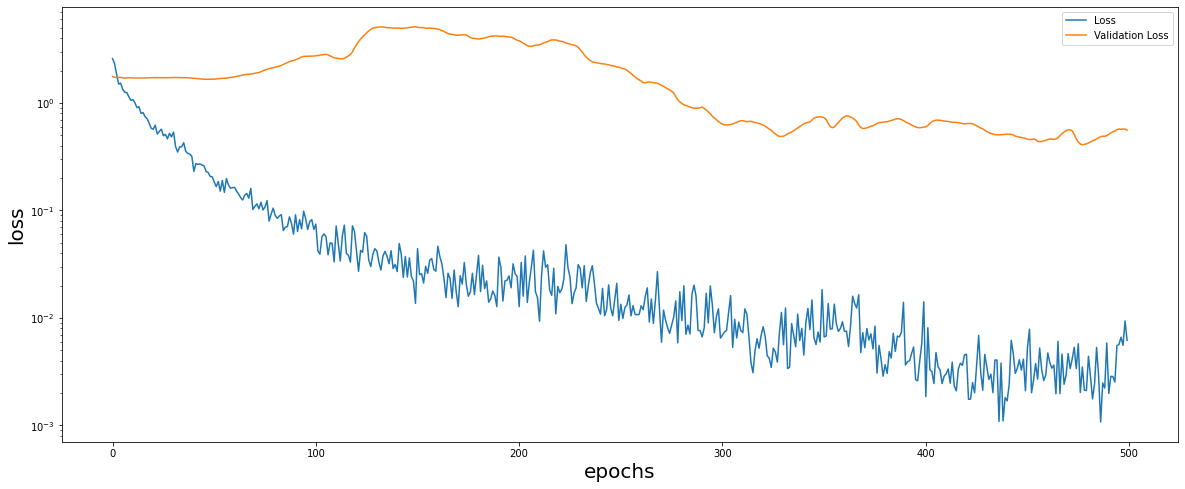

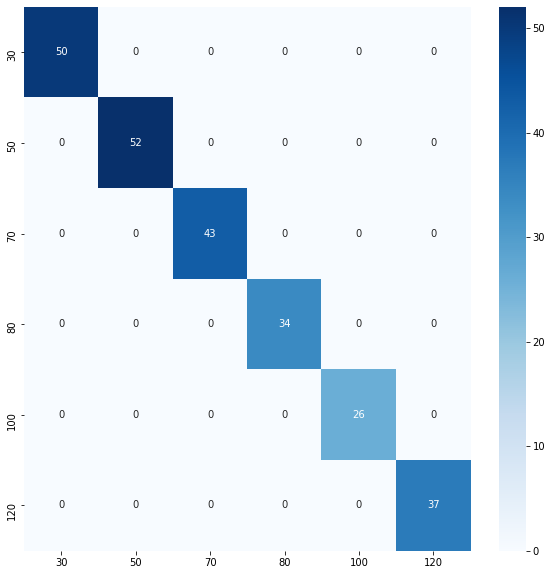

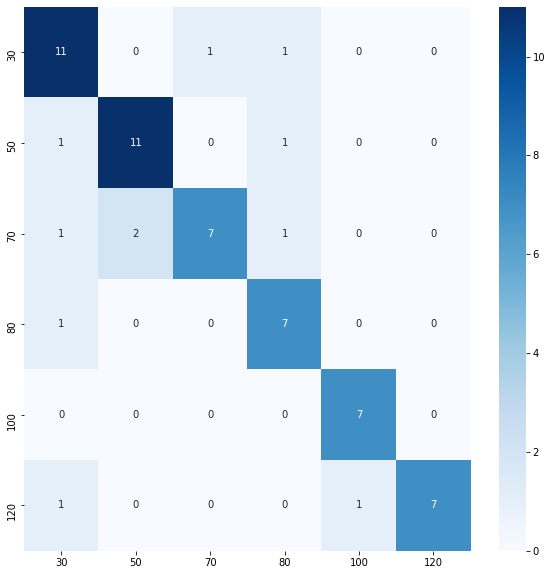

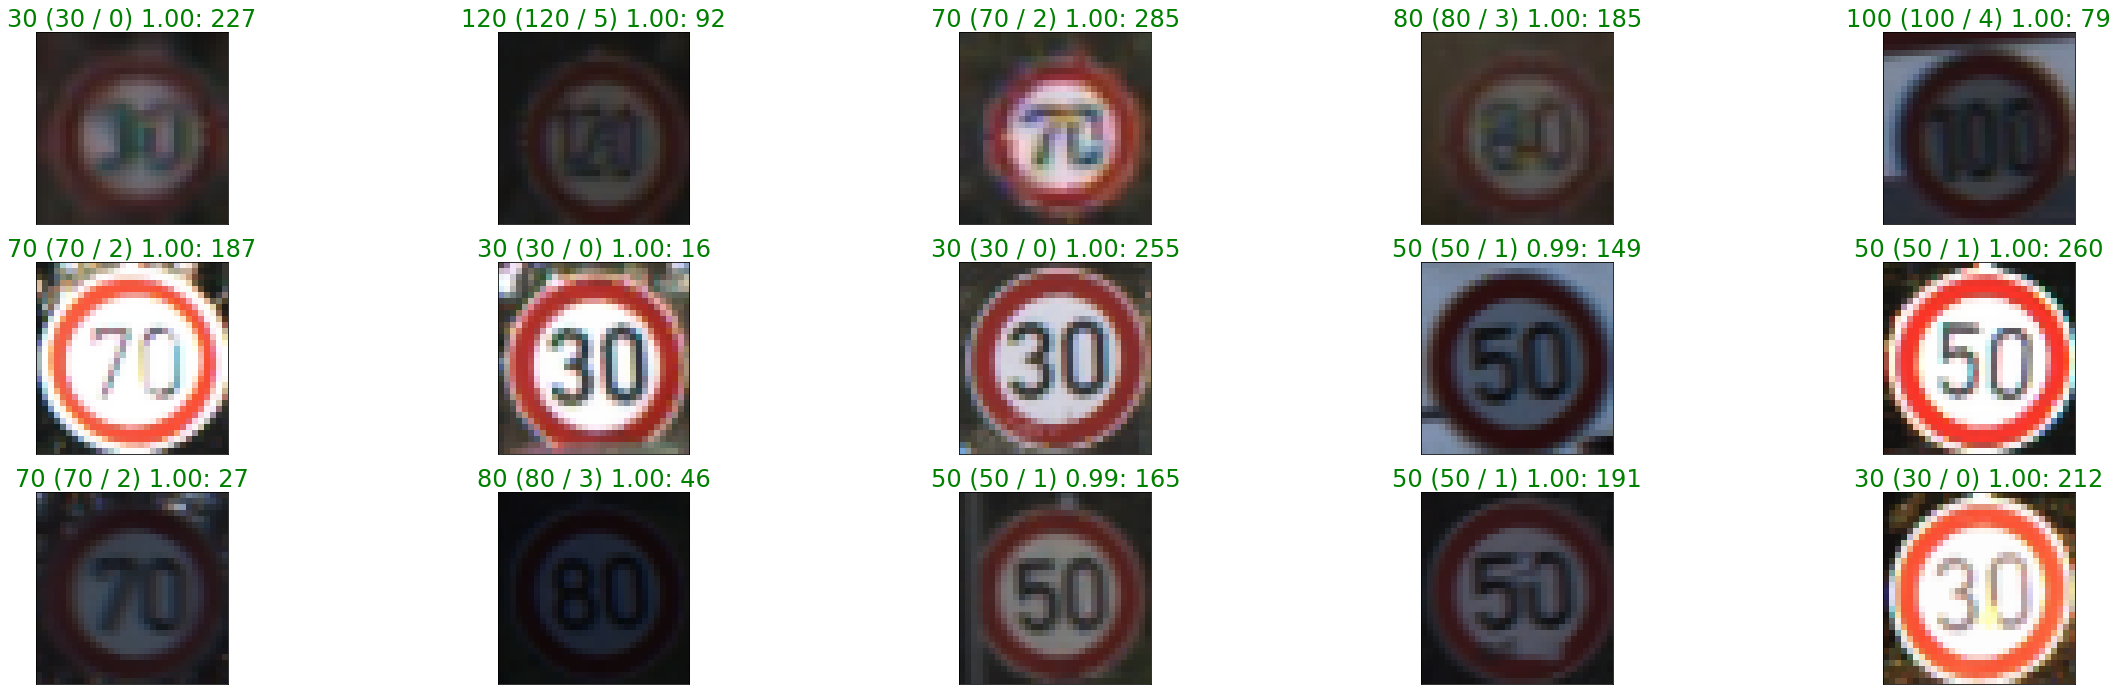

In [67]:
%%time

import shutil
shutil.rmtree('outputs', ignore_errors=True)
os.makedirs("outputs")

import mlflow
from mlflow import log_metric, log_param, log_artifacts

BN = True
DROPOUT = True
DROPOUT_RATE = 0.2

# highter batch size: more memory, maybe better generalization
BATCH_SIZE=200
EPOCHS = 500

KERNEL_SIZE = 2
FILTERS_BLOCK1 = 16
FILTERS_BLOCK2 = 32

CLASSIFIER_DIM = 256

# default
LEARNING_RATE = 0.001
# faster
# LEARNING_RATE = 0.01
# slower
# LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# SGD might generalize better
# default
# LEARNING_RATE = 0.01
# slower
# LEARNING_RATE = 0.005
# even slower
# LEARNING_RATE = 0.001
# faster
# LEARNING_RATE = 0.05
# even faster
# LEARNING_RATE = 0.1
# optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)

# https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.html
# https://mlflow.org/docs/latest/quickstart.html
# https://docs.databricks.com/applications/mlflow/index.html
with mlflow.start_run():

  model = tf.keras.Sequential(name='Custom_VGG')

  model.add(Conv2D(filters=FILTERS_BLOCK1, kernel_size=KERNEL_SIZE, padding='same', activation='relu', input_shape=(32, 32, 3))) 
  if BN:
    model.add(BatchNormalization())
  model.add(MaxPooling2D())
  if DROPOUT:
    model.add(Dropout(rate=DROPOUT_RATE))

  model.add(Conv2D(filters=FILTERS_BLOCK2, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
  if BN:
    model.add(BatchNormalization())
  model.add(MaxPooling2D())
  if DROPOUT:
    model.add(Dropout(rate=DROPOUT_RATE))

  model.add(Flatten())
  model.add(Dense(CLASSIFIER_DIM, activation='relu'))
  if BN:
    model.add(BatchNormalization())
  if DROPOUT:
    model.add(Dropout(rate=DROPOUT_RATE))
  model.add(Dense(classes, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
  model.summary()

  log_param("optimizer", optimizer.__class__.__name__)
  log_param("lr", LEARNING_RATE)
  log_param("batch size", BATCH_SIZE)
  log_param("batch normalization", BN)
  log_param("dropout", DROPOUT)
  log_param("dropout rate", DROPOUT_RATE)
  log_param("epochs", EPOCHS)
  log_param("architecture", model.name)
  log_param("kernel_size", KERNEL_SIZE)
  log_param("filters_block1", FILTERS_BLOCK1)
  log_param("filters_block2", FILTERS_BLOCK2)
  log_param("classifier_dim", CLASSIFIER_DIM)

  history = model.fit(X_experiment, y_experiment, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(X_val, y_val),
                      callbacks=[KerasLearningCurve()],
                      verbose=0
                      )
  
  loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE, verbose=0)
  train_loss, train_accuracy = model.evaluate(X_experiment, y_experiment, batch_size=BATCH_SIZE, verbose=0)
  val_loss, val_accuracy = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

  log_metric("train acc", train_accuracy)
  log_metric("val acc", val_accuracy)
  
  plot_accuracy(history, file_name='acc')
  plot_loss(history, file_name='loss')
  plot_cm(model, X_experiment, y_experiment, file_name='train_cm')
  plot_cm(model, X_val, y_val, file_name='val_cm')
  plot_gallery(model, X_train, y_train, file_name='train_gallery')

  # https://www.tensorflow.org/guide/keras/save_and_serialize
  model.save('outputs/model.h5')
  
  log_artifacts("outputs")

## Finally, try the model with test data to validate you have not overfitted implictly

_should be close to validation score_

In [68]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.47827374935150146, 0.8026315569877625)

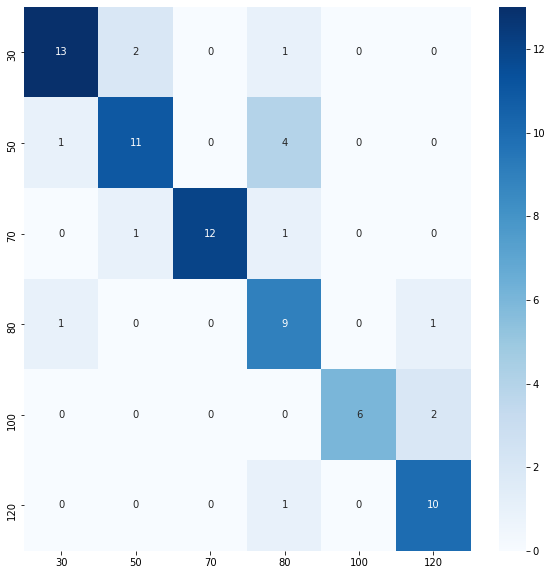

In [69]:
plot_cm(model, X_test, y_test)

# Alternative: Standard CNN Architectures (optional)

<img src='https://miro.medium.com/max/1400/1*n16lj3lSkz2miMc_5cvkrA.jpeg'>

https://towardsdatascience.com/neural-network-architectures-156e5bad51ba

### ResNet
* basic ideas
  * depth does matter
  * 8x deeper than VGG
  * possible by using shortcuts and skipping final fc layer
  * prevents vanishing gradient problem
* https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

http://arxiv.org/abs/1512.03385
![Deep Learning](https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/residual.png)

### Mobilenet

_MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications https://arxiv.org/abs/1704.04861_
  * Spares Dense Layers at the end, thus vastly reducing parameters

_MobileNetV2: Inverted Residuals and Linear Bottlenecks https://arxiv.org/abs/1801.04381_

* reduces computational load from ResNet
* uses Depthwise Separable Convolutions, which is much more efficient, but can not perform as many different filters
* recommended to try first, often simply gets the job done

https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728



## Keras Applications

Keras provides us with a lot of pre-defined network architectures for image classification (like ResNet and MobileNet)

https://keras.io/applications/

* Mobilenet: https://keras.io/applications/#mobilenet
  * final Logits layer has softmax activation: https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
* ResNet: https://keras.io/applications/#resnet50


In [70]:
# https://keras.io/api/applications/resnet/#resnet50v2-function

from tensorflow.keras.applications import ResNet50V2
model = ResNet50V2(classes=classes, weights=None, input_shape=(32, 32, 3))
# model.summary()
len(model.layers)

192

# Exercise: Choose a standard architecture (there are more) and try it against our custom model

* use the existing code above and simply replace the model
* use the code above for the new model
* regularization already is in place, if you need more tweak BATCH_SIZE, EPOCHS and use SGD



# Optional: Fine grained analysis of training results

In [71]:
!ls -l outputs

total 6552
-rw-r--r-- 1 root root   45788 May 14 17:41 acc.png
-rw-r--r-- 1 root root   76581 May 14 17:41 loss.png
-rw-r--r-- 1 root root 6423320 May 14 17:41 model.h5
-rw-r--r-- 1 root root   14843 May 14 17:41 train_cm.png
-rw-r--r-- 1 root root  121286 May 14 17:41 train_gallery.png
-rw-r--r-- 1 root root   13788 May 14 17:41 val_cm.png


In [72]:
model = tf.keras.models.load_model('outputs/model.h5')
model.name

'Custom_VGG'

## Training data

In [73]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([63, 65, 54, 42, 33, 46]))

(1.0, 0.4175407, 0.98139524)

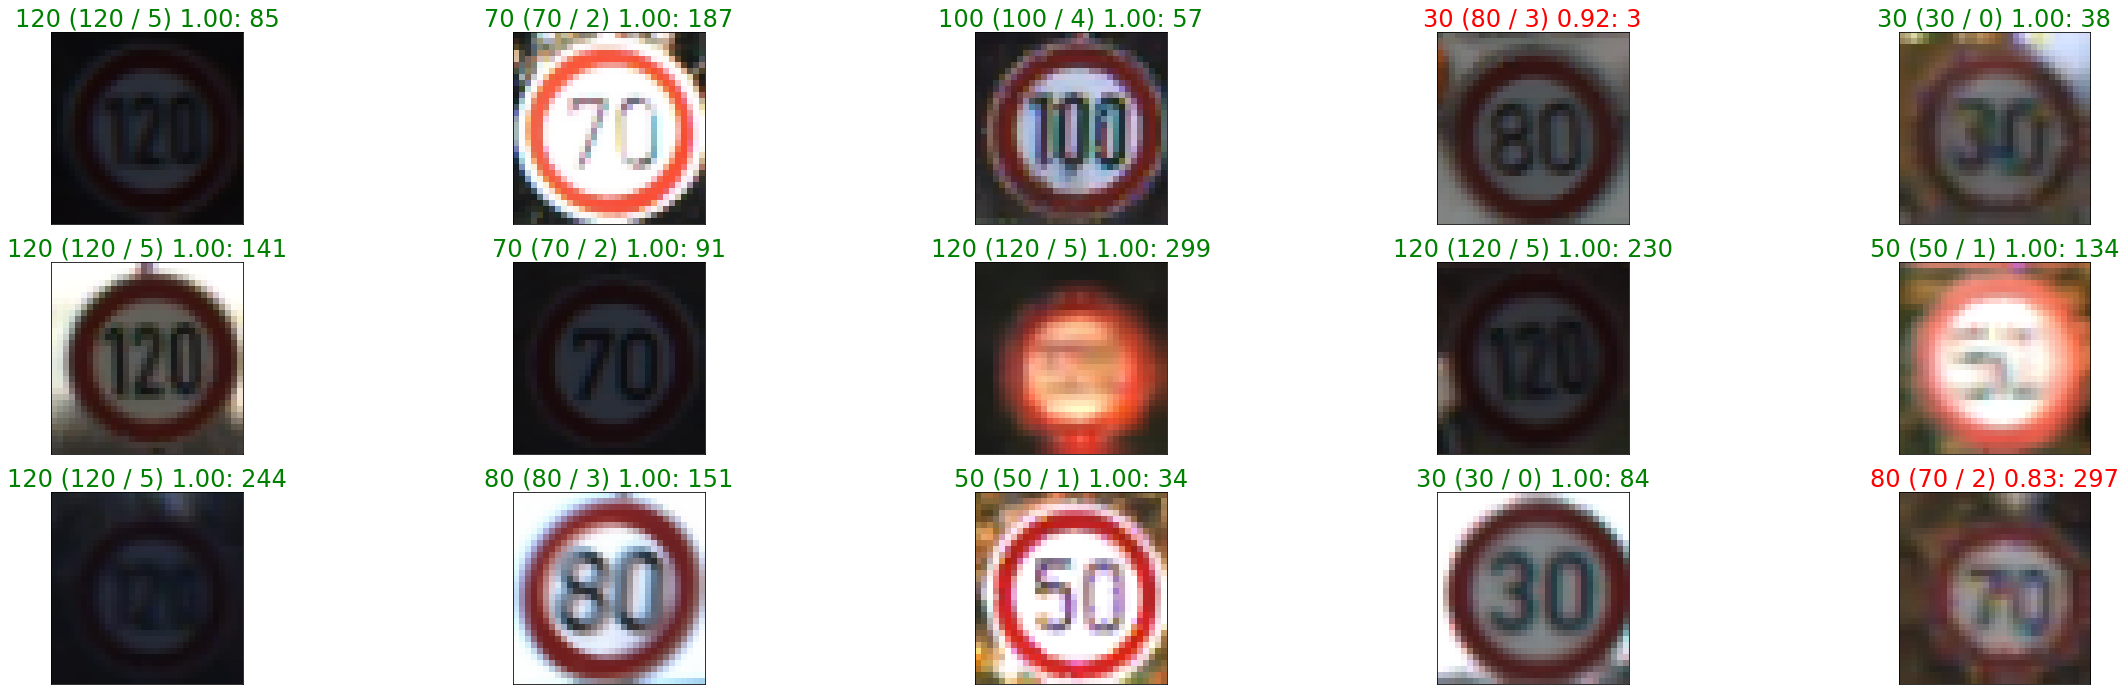

In [74]:
plot_gallery(model, X_train, y_train)

## Test data

In [75]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([16, 16, 14, 11,  8, 11]))

(0.99998474, 0.38716903, 0.8830252)

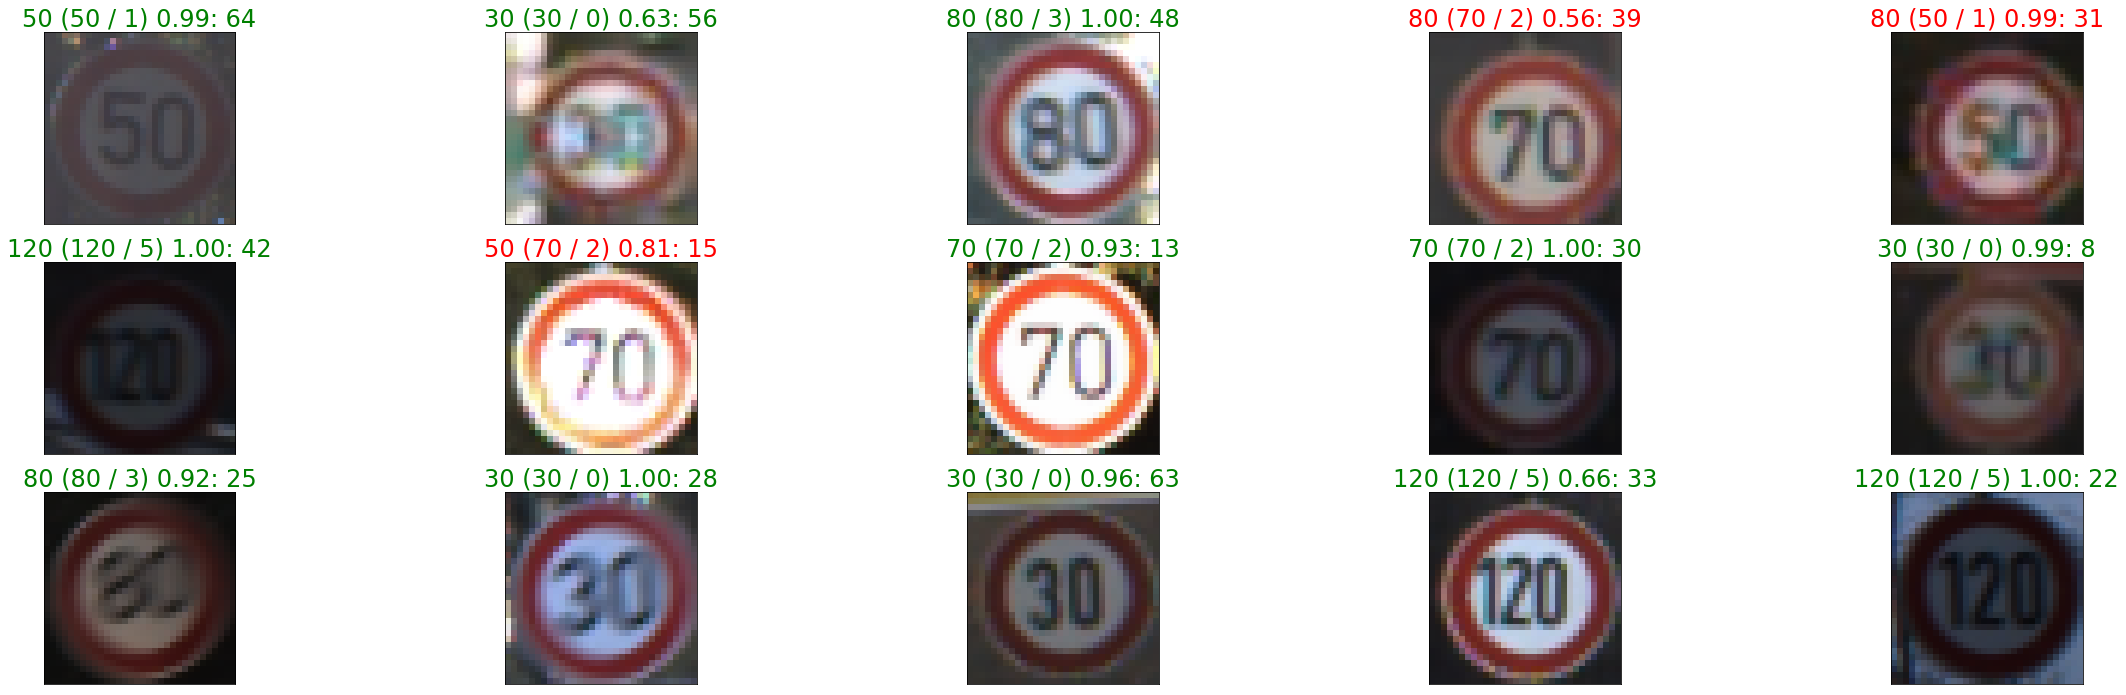

In [76]:
plot_gallery(model, X_test, y_test)

## Individual categories

In [77]:
cat_nr = 0

In [78]:
categories = np.unique(y_test, return_inverse=True)[1]
# categories

In [79]:
cat = np.where(categories == cat_nr)
# cat

(0.999629, 0.5280479, 0.87606186)

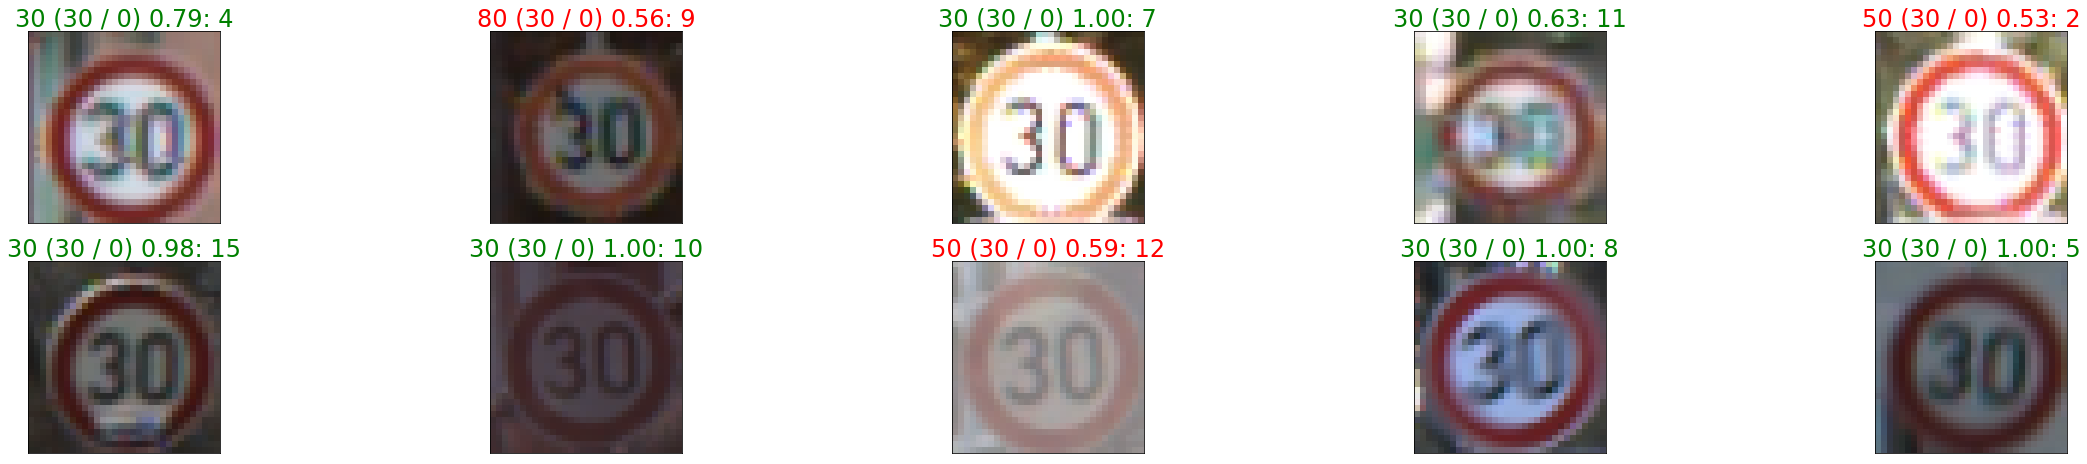

In [80]:
plot_gallery(model, X_test[cat], y_test[cat], size=10)

## Low certainty

In [81]:
y_pred_raw = model.predict(X, batch_size=BATCH_SIZE)
certainty = y_pred_raw.max(axis=1)
certainty.max(), certainty.min(), certainty.mean()

(1.0, 0.387169, 0.9616694)

In [90]:
threshold = 0.6

In [91]:
certainty_cat = np.where(certainty < threshold)
certainty_cat

(array([ 26,  70, 165, 168, 186, 189, 283, 332, 352, 360]),)

(0.58557594, 0.38716888, 0.5025099)

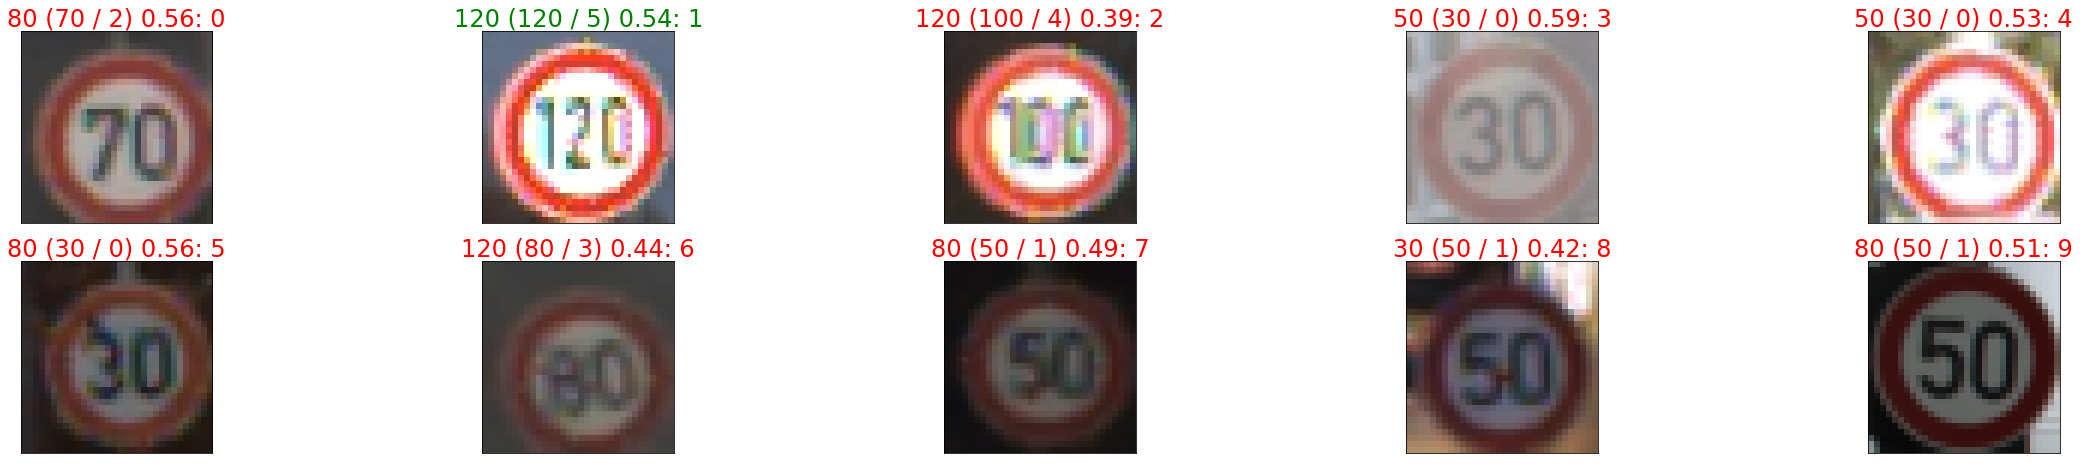

In [92]:
plot_gallery(model, X[certainty_cat], y[certainty_cat], size=None)

## Wrong ones

In [93]:
y_pred_raw = model.predict(X, batch_size=BATCH_SIZE)
y_pred = y_pred_raw.argmax(axis=1)

In [94]:
wrong_cat = np.where(y_pred != y)
wrong_cat

(array([  6,  24,  26,  28,  50,  59,  68,  74,  86, 126, 165, 168, 186,
        189, 194, 200, 262, 276, 283, 312, 332, 338, 344, 352, 360, 369]),)

(0.99385947, 0.38716906, 0.69918096)

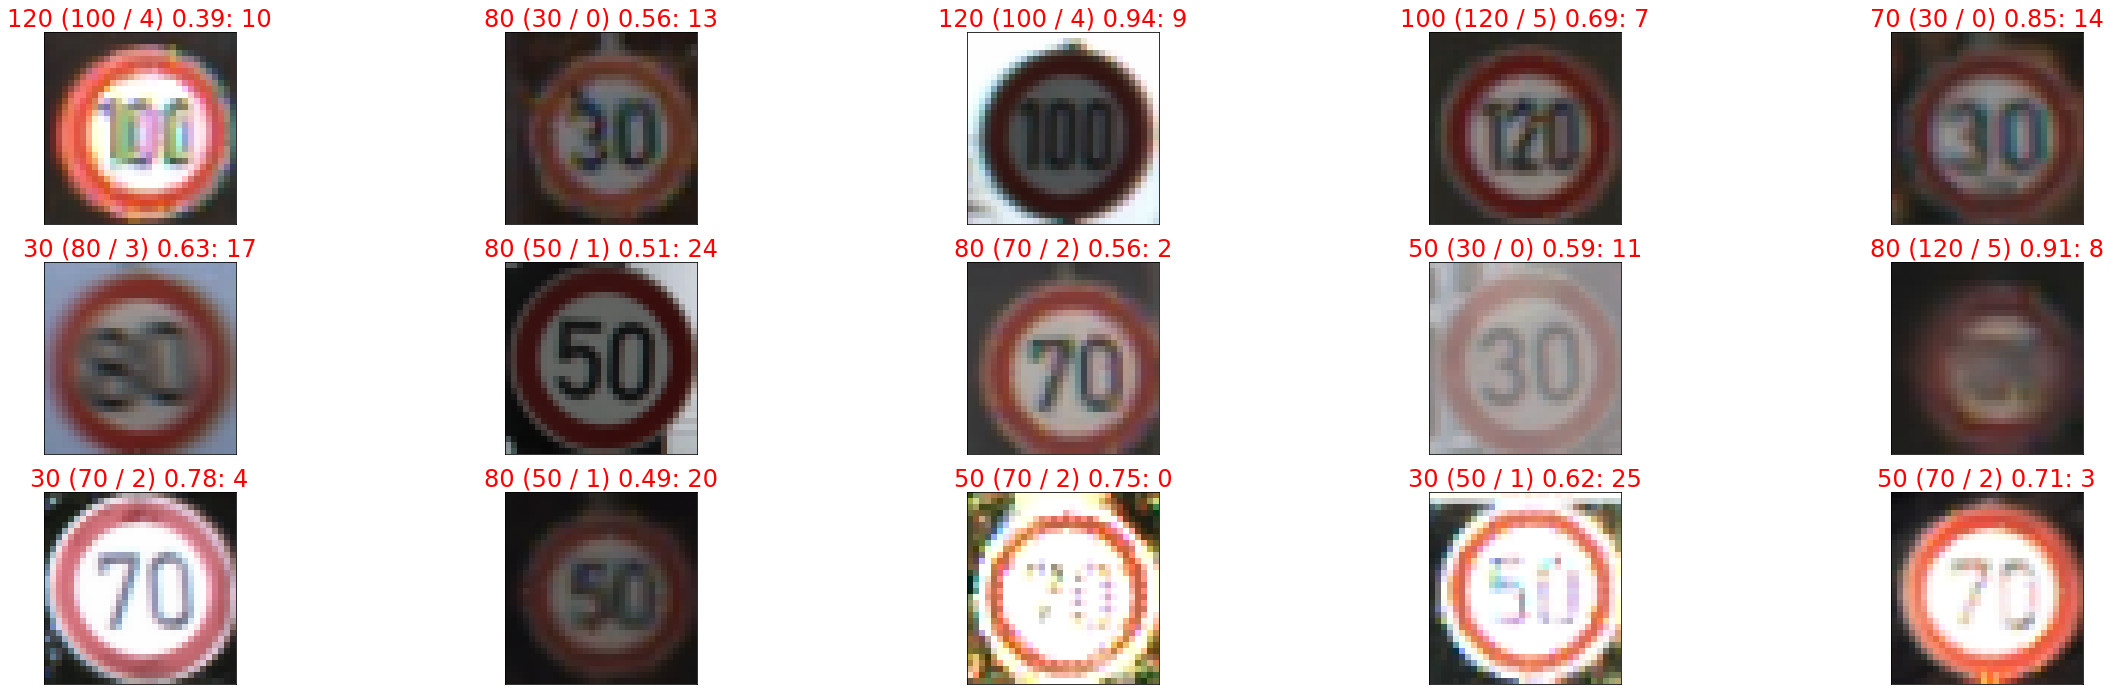

In [95]:
plot_gallery(model, X[wrong_cat], y[wrong_cat])

## Rights ones

In [96]:
y_pred_raw = model.predict(X, batch_size=BATCH_SIZE)
y_pred = y_pred_raw.argmax(axis=1)

In [97]:
right_cat = np.where(y_pred == y)
right_cat

(array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  27,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  51,  52,  53,  54,  55,  56,
         57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  69,  70,  71,
         72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166,
        167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 187, 188, 190, 191

(1.0, 0.5411578, 0.98100287)

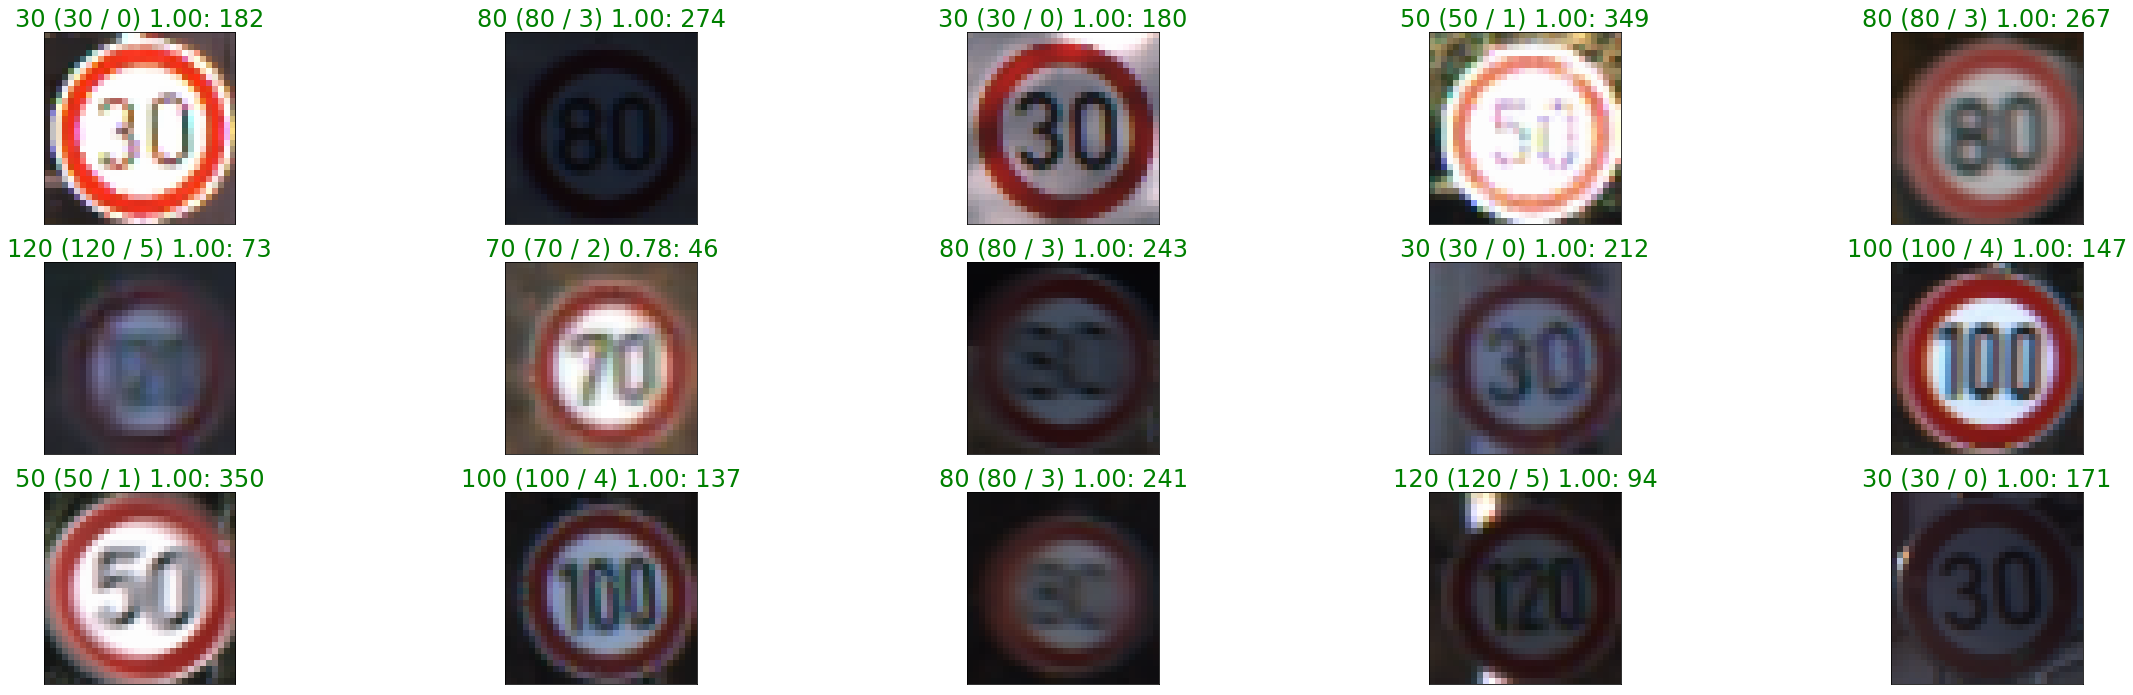

In [98]:
plot_gallery(model, X[right_cat], y[right_cat])

# Exercise: Can you draw any conclusions from this analysis?

* What are open questions?
* What could you do to improve the training result?

# Optional: What part of the image does the network use?

In [99]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

from tensorflow.keras import backend as K

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m


def plot_map(index, map_only=False):
    image = X[index]
    label = y[index]

    saliency_images = np.array([image], dtype='float32')
    
    def input_output_mapping(output):
        return (output[0][label])
    
    saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

    saliency_map = saliency(input_output_mapping, saliency_images)
    saliency_map = normalize(saliency_map)
    
    if map_only:
      plt.imshow(saliency_map[0], cmap='jet')
    else:
      plt.imshow(image);
      plt.imshow(saliency_map[0], cmap='jet', alpha=0.3);


(1.0, 0.387169, 0.9616694)

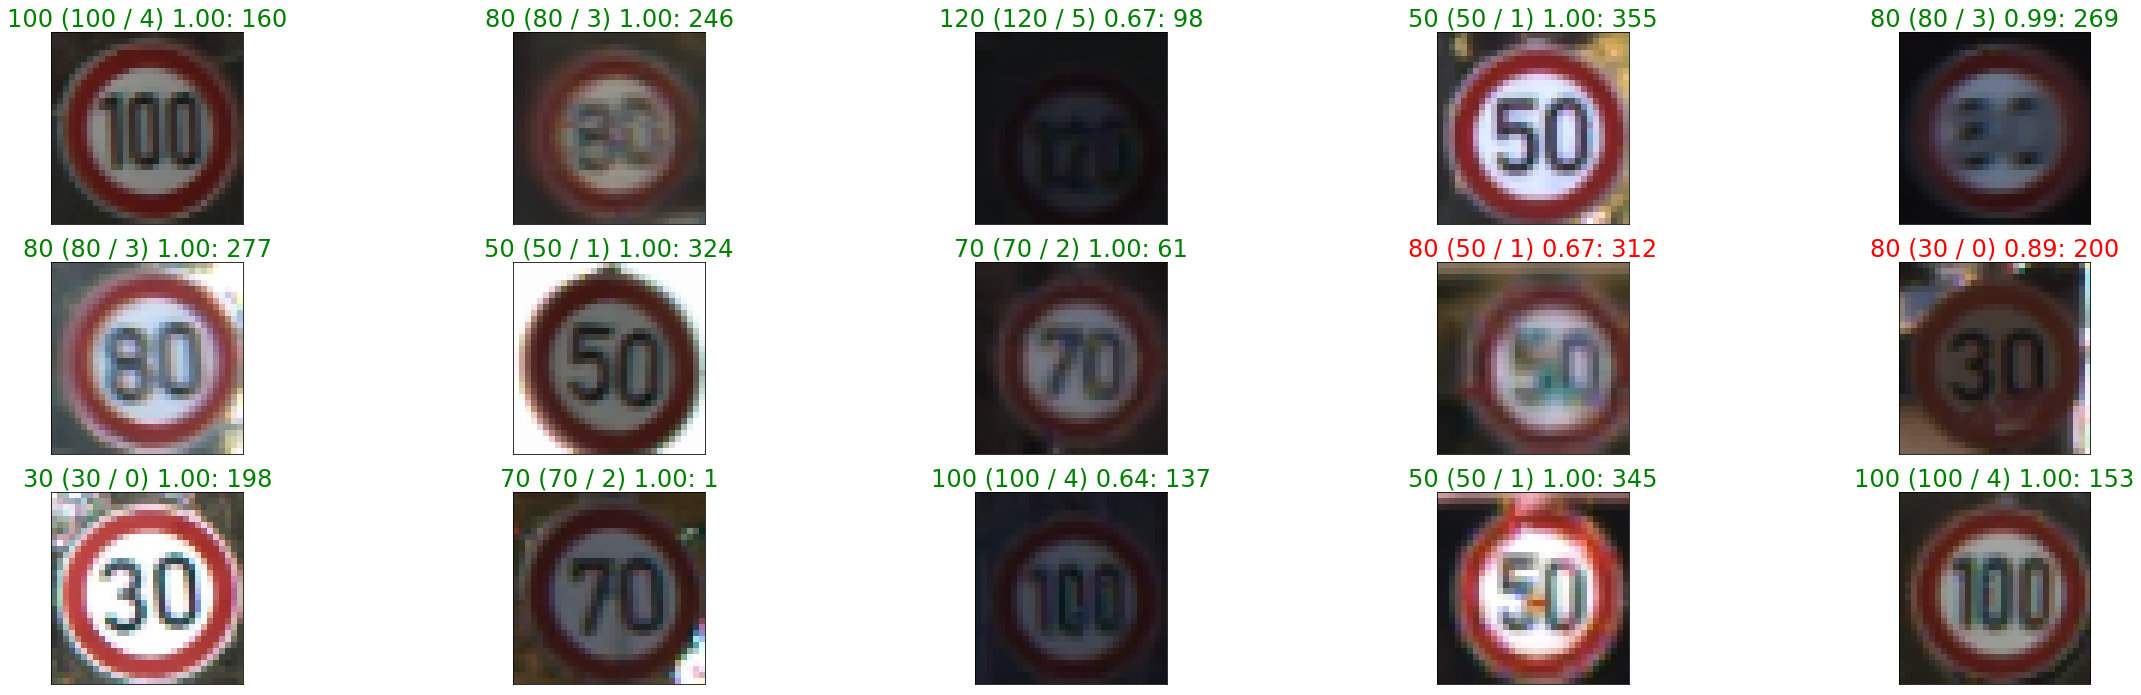

In [100]:
plot_gallery(model, X, y)

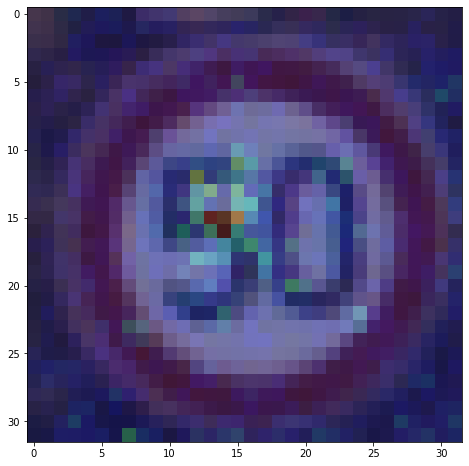

In [101]:
index = 359
plot_map(index)
# plot_map(index, map_only=True)

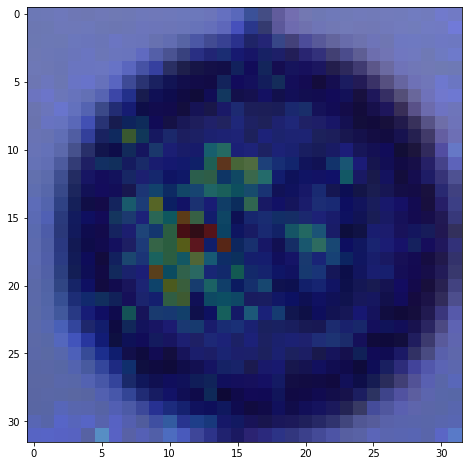

In [102]:
plot_map(248)
# plot_map(248, map_only=True)

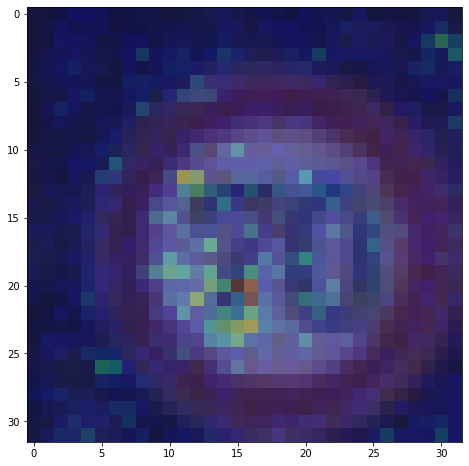

In [103]:
plot_map(54)
# plot_map(54, map_only=True)

# Exercise: Try saliency maps with more images

* Would you say the training is a success?
* What does the prediction concentrate on?
* Do you see differences between the groups we analyzed before?

# Compare with pure Dense Layers
* more parameters for classifier as we feed in raw image input
  * especially bad for large resolutions
* does not use geometric prior of images, generalizes worse in real world settings
* might train faster on CPU

In [104]:
%%time

from tensorflow.keras.layers import Dense, Dropout, Flatten

DROPOUT_RATE = 0.5

model = tf.keras.Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=DROPOUT_RATE))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

BATCH_SIZE = 50
EPOCHS = 500

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.2,
                    callbacks=[KerasLearningCurve()],
                    verbose=0
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 3078      
Total params: 1,576,454
Trainable params: 1,576,454
Non-trainable params: 0
_________________________________________________________________


CPU times: user 38.6 s, sys: 1.92 s, total: 40.5 s
Wall time: 40.1 s


In [105]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.04527336359024048, 0.9966996908187866)

In [106]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.22498582303524017, 0.9473684430122375)

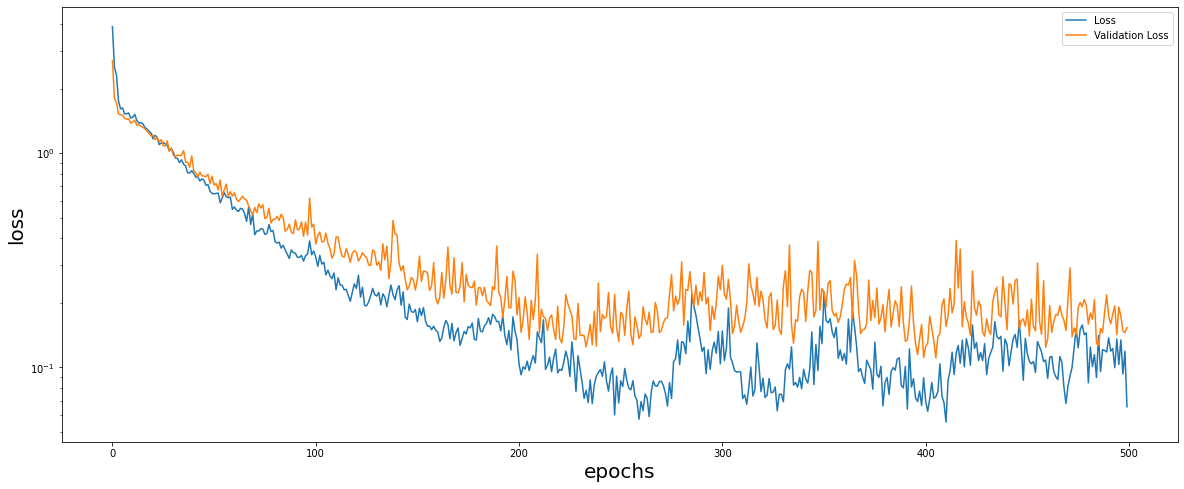

In [107]:
plot_loss(history)

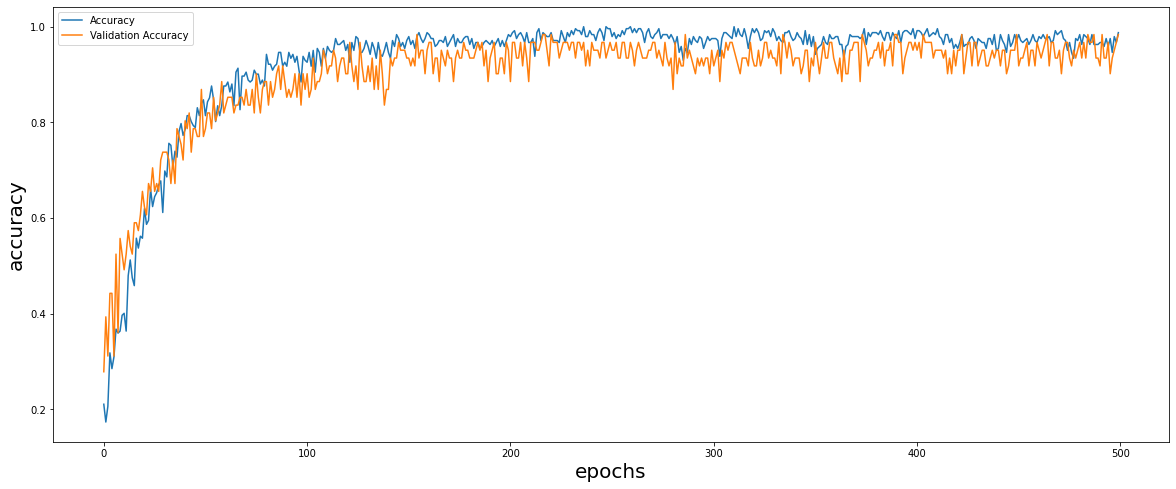

In [108]:
plot_accuracy(history)

In [109]:
y_pred = model.predict(X).argmax(axis=1)
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,

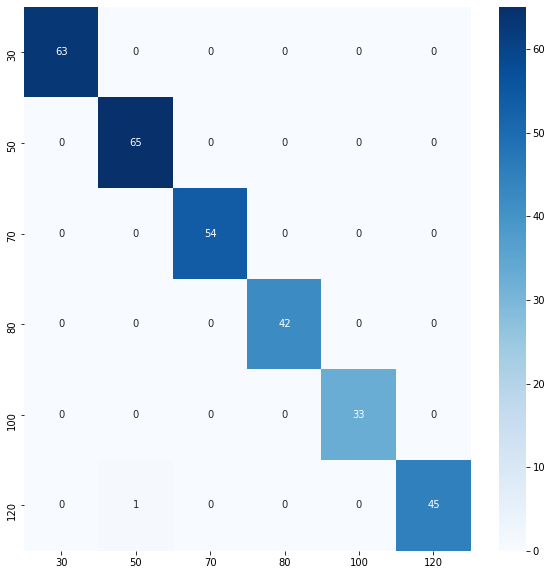

In [110]:
# * row: true
# * column: predicted

plot_cm(model, X_train, y_train)

(1.0, 0.32155165, 0.96437526)

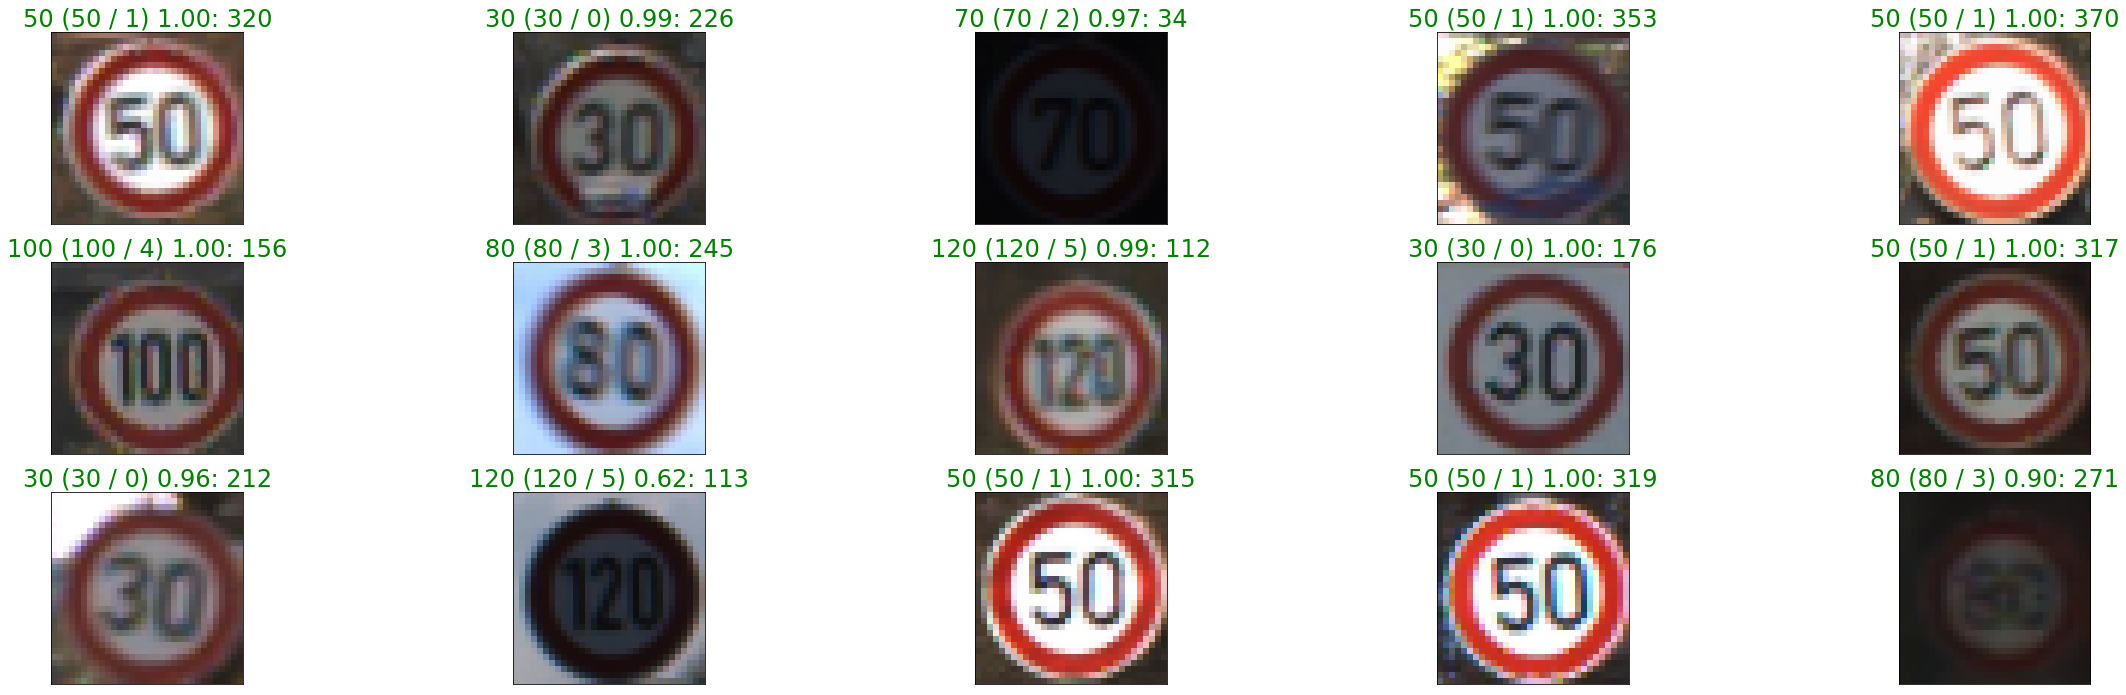

In [111]:
plot_gallery(model, X, y)